# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
validation_file = 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
print(len(y_train))
print(len(y_valid))
print(len(y_test))
print(X_test.shape)
print(X_test.shape[0])
print(test['labels'])

34799
4410
12630
(12630, 32, 32, 3)
12630
[16  1 38 ...,  6  7 10]


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of validation examples
n_valid = len(y_valid)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.max(y_train) - np.min(y_train) + 1

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


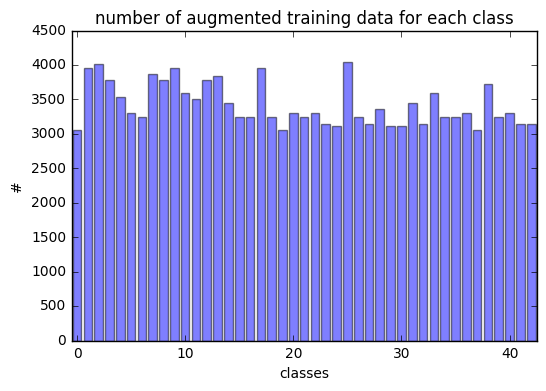

In [33]:
import matplotlib.pyplot as plt

n_data_of_classes = np.zeros((n_classes,))
for i in range(n_classes):
    n_data_of_classes[i] = len(y_train[y_train == i])
#     print('Number of training example for class %d = %d' 
#           %(i, len(y_train[y_train == i])))
# print(n_data_of_classes)

classes_num = [i for i in range(43)]

plt.bar(classes_num, n_data_of_classes, align="center", alpha=.5 )
plt.title('number of augmented training data for each class')
plt.xlabel('classes')
plt.ylabel('#')
plt.xlim([0-.5, classes_num[-1]+.5])
# plt.savefig('data_distribution_augmented.png')
plt.show()

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [5]:
# import packages
import tensorflow as tf
import random
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten



3
uint8
(34799,)


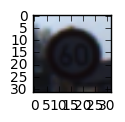

In [6]:
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

print(X_train[index].dtype)
print(y_train.shape)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [7]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.
generate_distorted_images = False
use_augmented_training_set = True

In [8]:
# Print iterations progress (http://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console)
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

In [9]:
## Generate distorted images for augmented training set
from PIL import Image
from PIL import ImageEnhance

if generate_distorted_images == True:
    # set progressbar
    N_rand_total = np.sum(np.floor(3000/n_data_of_classes) * n_data_of_classes)
    N_rand_total = N_rand_total.astype(int)
    N_now = 0
    
    printProgressBar(N_now, N_rand_total, prefix = 'Progress:', suffix = 'Complete', length = 50)
    
    # initialize augmented (X,y)
    X_train_augmented = X_train
    y_train_augmented = y_train

    for i in range(X_train.shape[0]):
        # If you have less than 3000 data, you increase the number of data by random cropping.
        if n_data_of_classes[y_train[i]] <= 3000: 
            N_rand = np.floor(3000/n_data_of_classes[y_train[i]])
            N_rand = N_rand.astype(int)

        for j in range(N_rand):
            
            N_now += 1
            
            # load training images
            X_train_PIL = Image.fromarray(X_train[i,:,:,:])
            
            # set width(=height) and start points for random cropping
            rw = np.floor(random.random()*12 + 18) # random width (18~30)
            rw = int(rw)
            rs = np.floor((32 - rw) * random.random()) # random crop start point
            rs = int(rs)

            # randomly crop and reshape to (32,32,3)
            randomly_cropped_image = X_train_PIL.crop((rs,rs,rs+rw,rs+rw))
            distorted_image = randomly_cropped_image.resize((32,32), Image.ANTIALIAS)

            # randomly adjust brightness
            enhancer = ImageEnhance.Brightness(distorted_image)
            distorted_image_ = enhancer.enhance(random.random())

            # convert image to uint8 array
            distorted_image_ = np.array(distorted_image_, dtype=np.uint8)

            # append distorted image on X_train
            distorted_image_ = distorted_image_[np.newaxis,:] # (expand dimension from (32,32,3) to (1,32,32,3))
            X_train_augmented = np.append(X_train_augmented, distorted_image_, axis=0)
            y_train_augmented = np.append(y_train_augmented, [y_train[i]], axis=0)
            
            printProgressBar(N_now, N_rand_total, prefix = 'Progress:', suffix = 'Complete', length = 50)

    print("augmented training images are generated.")
    print("%d -> %d" %(X_train.shape[0], X_train_augmented.shape[0]))

In [10]:
# save augmented training set as file
if generate_distorted_images == True:
    np.save('X_train_augmented', X_train_augmented)
    np.save('y_train_augmented', y_train_augmented)
    print('Augmented training data is saved.')
    
# load augmented training set as file
if use_augmented_training_set == True:
    X_train = np.load('X_train_augmented.npy')
    y_train = np.load('y_train_augmented.npy')
    print('Augmented training data is loaded.')

Augmented training data is loaded.


In [11]:
# normalize images into [-0.5, 0.5]
# after normalization, images become float64 type.
def normalize_images(X_):
    return X_ / 255 - 0.5

X_train_ = normalize_images(X_train)
print('training set is normalized')

X_valid_ = normalize_images(X_valid)
print('Validation set is normalized')

X_test_ = normalize_images(X_test)
print('Test set is normalized')

training set is normalized
Validation set is normalized
Test set is normalized


### Model Architecture

In [12]:
# tensorflow graph input
x = tf.placeholder(tf.float64, (None, 32, 32, 3))
x = tf.cast(x, tf.float32)
y = tf.placeholder(tf.uint8, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

In [13]:
# parameters
rate = 0.002
EPOCHS = 500
BATCH_SIZE = 5000
display_step = 5
save_step = 5

# do train?
do_train = 0
epoch_to_restore = 590

# select device to be used
device_type = "/gpu:0"

In [14]:
### LeNet with Dropout/batch normalization
with tf.device(device_type):
    def LeNet(x, keep_prob):    
        # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
        mu = 0
        sigma = 0.1

        # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x32.
        conv1_w = tf.Variable(tf.truncated_normal(shape=(5,5,3,32), mean=mu, stddev=sigma))
        conv1_b = tf.Variable(tf.zeros(32))
        conv1 = tf.nn.conv2d(x, conv1_w, strides=[1,1,1,1], padding='VALID') + conv1_b
        mean_, var_ = tf.nn.moments(conv1, [0,1,2])
        conv1 = tf.nn.batch_normalization(conv1, mean_, var_, 0, 1, 0.0001)
        
        
        # TODO: Activation.
        conv1 = tf.nn.relu(conv1)
        conv1 = tf.nn.dropout(conv1, keep_prob)

        # TODO: Pooling. Input = 28x28x32. Output = 14x14x32.
        conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1],strides=[1,2,2,1], padding='VALID')

        # TODO: Layer 2: Convolutional. Output = 10x10x64.
        conv2_w = tf.Variable(tf.truncated_normal(shape=(5,5,32,64), mean=mu, stddev=sigma))
        conv2_b = tf.Variable(tf.zeros(64))
        conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1,1,1,1], padding='VALID') + conv2_b 
        mean_, var_ = tf.nn.moments(conv2, [0,1,2])
        conv2 = tf.nn.batch_normalization(conv2, mean_, var_, 0, 1, 0.0001)
        
        
        # TODO: Activation.
        conv2 = tf.nn.relu(conv2)
        conv2 = tf.nn.dropout(conv2, keep_prob)

        # TODO: Pooling. Input = 10x10x64. Output = 5x5x64.
        conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

        # TODO: Flatten. Input = 5x5x64. Output = 1600.
        fc0 = flatten(conv2)

        # TODO: Layer 3: Fully Connected. Input = 1600. Output = 120.
        fc1_w = tf.Variable(tf.truncated_normal(shape=(1600,120), mean=mu, stddev=sigma))
        fc1_b = tf.Variable(tf.zeros(120))
        fc1 = tf.matmul(fc0, fc1_w) + fc1_b

        # TODO: Activation.
        fc1 = tf.nn.relu(fc1)
        fc1 = tf.nn.dropout(fc1, keep_prob)

        # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
        fc2_w = tf.Variable(tf.truncated_normal(shape=(120,84), mean=mu, stddev=sigma))
        fc2_b = tf.Variable(tf.zeros(84))
        fc2 = tf.matmul(fc1, fc2_w) + fc2_b

        # TODO: Activation.
        fc2 = tf.nn.relu(fc2)
        fc2 = tf.nn.dropout(fc2, keep_prob)

        # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
        fc3_w = tf.Variable(tf.truncated_normal(shape=(84,43), mean=mu, stddev=sigma))
        fc3_b = tf.Variable(tf.zeros(43))
        logits = tf.matmul(fc2, fc3_w) + fc3_b

        return logits

print('LeNet is ready')

LeNet is ready


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [15]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [16]:
with tf.device(device_type):
    logits = LeNet(x, keep_prob)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
    loss_operation = tf.reduce_mean(cross_entropy)

    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    training_operation = optimizer.minimize(loss_operation)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [17]:
saver = tf.train.Saver()

## Optimize!

In [44]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    if do_train == 1:
        num_examples = len(X_train_)

        print("Training...")
        print()
        for epoch in range(EPOCHS):
            avg_loss = 0.
            total_batch = int(num_examples/BATCH_SIZE)

            X_train_, y_train = shuffle(X_train_, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train_[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
                avg_loss += sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})/total_batch

            if epoch % display_step == 0:
                train_acc = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
                valid_acc = sess.run(accuracy_operation, feed_dict={x: X_valid_, y: y_valid, keep_prob: 1})
                
                print("Epoch : %03d/%03d, loss: %.9f, training acc: %.3f, valid acc: %.3f" 
                      % (epoch, EPOCHS, avg_loss, train_acc, valid_acc))

            if epoch % save_step == 0:
                saver.save(sess, "nets/traffic_sign_lenet-" + str(epoch))
#                 print("Model saved")
                
        test_acc = sess.run(accuracy_operation, feed_dict={x: X_test_, y:y_test, keep_prob: 1})        
        print("Test accuracy: %.3f" % (test_acc))
    
    if do_train == 0:
#         epoch = epoch_to_restore
        saver.restore(sess, tf.train.latest_checkpoint('nets/'))
        print("Model restored.")
        
        # calculate training accuracy
        batch_size_for_cal = 10000
        n_train_right = 0
        offset = 0
        tstep = np.floor(X_train_.shape[0]/10000)
        for t in range(tstep.astype(int)):            
            if X_train_.shape[0] - (batch_size_for_cal + offset) < 0:
                batch_size_for_cal = X_train_.shape[0] - offset
            n_train_right += sess.run(accuracy_operation, 
                                     feed_dict={x: X_train_[offset:offset+batch_size_for_cal],
                                                y: y_train[offset:offset+batch_size_for_cal], keep_prob: 1}) * batch_size_for_cal
        
        train_acc = n_train_right/X_train_.shape[0]
        
        # validation and test accuracy
        valid_acc = sess.run(accuracy_operation, feed_dict={x: X_valid_, y: y_valid, keep_prob: 1})
        test_acc = sess.run(accuracy_operation, feed_dict={x: X_test_, y:y_test, keep_prob: 1})
        print("Training accuracy: %.3f" % (train_acc))
        print("Validation accuracy: %.3f" % (valid_acc))
        print("Test accuracy: %.3f" % (test_acc))


Model restored.
Training accuracy: 0.933
Validation accuracy: 0.942
Test accuracy: 0.926


## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

Five pictures of German traffic signs from the web:


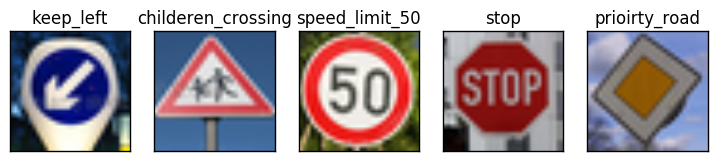

img_set size: (5, 32, 32, 3)


In [19]:
### Load the images and plot them here.
# Import images from folder
import os
from PIL import Image

img_set = np.ones(shape=(5,32,32,3))
n_test_img = 0
target_img_file_names = []

print('Five pictures of German traffic signs from the web:')

fig = plt.figure(figsize=(9,3))

for img_file in os.listdir("./german_traffic_signs"): 
    if img_file.endswith(".png"):
        # save file name
        target_img_file_names.append(img_file)
        
        # load images and resize it to (32,32,3)
        img = Image.open('./german_traffic_signs/' + img_file).convert('RGB') # load image into RGB
        img = img.resize((32,32), Image.ANTIALIAS) # resizes image in-place
        
        # append image as (N, 32, 32, 3) 
        img_set[n_test_img,:,:,:] = np.array(img, dtype=np.float32)/1.0
        n_test_img += 1
        
        # Print the names and pictures of the target images
        ax_ = fig.add_subplot(1, 5, n_test_img)
        ax_.imshow(img, cmap="gray")
        ax_.set_title(img_file[5:-4])
        ax_.set_xticks([])
        ax_.set_yticks([])
# plt.savefig('five_test_images.png')
plt.show()
        
# print appended image shape
print('img_set size: ' + str(img_set.shape))

### Predict the Sign Type for Each Image

In [20]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
X_img_test = normalize_images(img_set)

with tf.Session(config=config) as sess:
    epoch = epoch_to_restore
    saver.restore(sess, tf.train.latest_checkpoint('nets/'))
    predict_type = sess.run(tf.argmax(logits, 1), feed_dict={x: X_img_test, keep_prob: 1.0})
    print(predict_type)

[39 29  2 14 12]


In [21]:
print(predict_type.dtype)
print(predict_type[0])
print(predict_type[1])

int64
39
29


In [22]:
import csv
with open('signnames.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    print(reader)
    SignNames = []
    for row in reader:
        csv_ = row['SignName']
        SignNames.append(csv_)

In [23]:
for predict_ind in range(len(predict_type)):
#     print('%s' % (SignNames[predict_type[predict_ind]]))
#     print('%s %s' %(target_img_file_names[predict_ind] , SignNames[predict_type[predict_ind]]))
    print('File name: %-025s Predicted name: %s'%(target_img_file_names[predict_ind][5:-4] , SignNames[predict_type[predict_ind]]))

File name: keep_left                 Predicted name: Keep left
File name: childeren_crossing        Predicted name: Bicycles crossing
File name: speed_limit_50            Predicted name: Speed limit (50km/h)
File name: stop                      Predicted name: Stop
File name: prioirty_road             Predicted name: Priority road


### Analyze Performance

In [24]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
y_new_true = [39, 28, 2, 14, 12] # keep left (39), children crossing (28), speed limit (2), stop (14), prioirty road (12)

with tf.Session(config=config) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('nets/'))
    test_img_acc = sess.run(accuracy_operation, feed_dict={x: X_img_test, y: y_new_true, keep_prob: 1})
    y_new_pred = sess.run(tf.argmax(logits, 1), feed_dict={x: X_img_test, keep_prob: 1.0})
    print('The accuracy for these 5 new images: %.2f' % (test_img_acc))

The accuracy for these 5 new images: 0.80


In [25]:
### Create confusion matrix using test set
## test set prediction
with tf.Session(config=config) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('nets/'))
    y_test_pred = sess.run(tf.argmax(logits, 1), feed_dict={x: X_test_, keep_prob: 1.0})


In [26]:
## configure confussion matrix
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.title(title)
    
    tick_marks = np.arange(len(classes))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    # write the values of confusion matrix
    cm_font ={'size': '7'}
    tick_font = {'size': '8'}
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i,j] >= 0.02:
            plt.text(j, i, '{:.2f}'.format(cm[i, j])[1:],
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     **cm_font)
        
    
    plt.xticks(tick_marks, classes, **tick_font)
    plt.yticks(tick_marks, classes, **tick_font)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.tight_layout()
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.colorbar()
    plt.grid()

Normalized confusion matrix


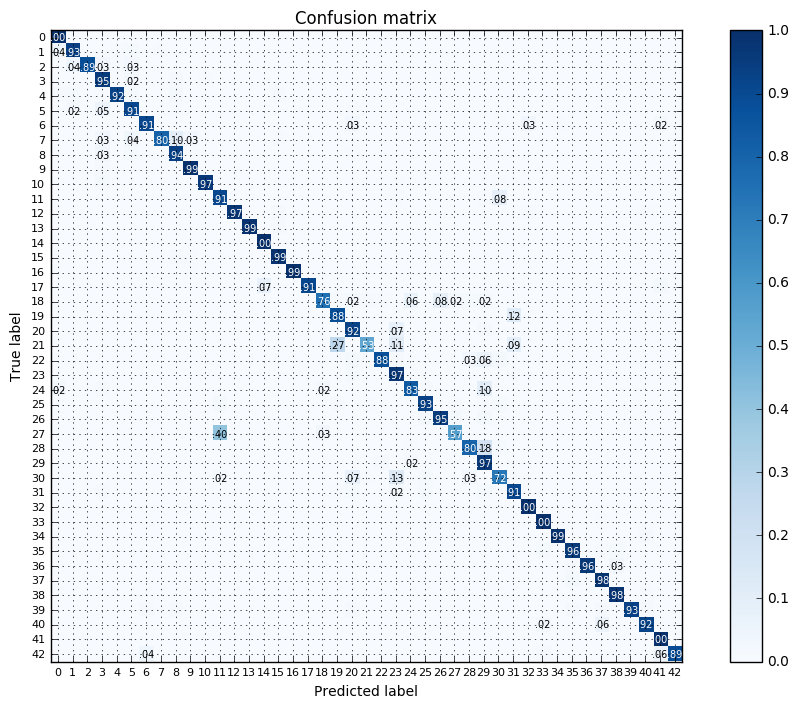

In [27]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)
classes = [str(i) for i in range(len(SignNames))]

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,7))
plot_confusion_matrix(cnf_matrix, classes=classes, title='Confusion matrix', normalize=True)
# plt.savefig('confusion_matrix.png')
plt.show()


In [28]:
import matplotlib.gridspec as gridspec
def plot_test_images(images, nc = 15, nr = 4):
    ct = 0
    fig = plt.figure(figsize=(nc, nr))
    gs = gridspec.GridSpec(nr, nc)
    gs.update(wspace=0.0, hspace=0.0)
    for i in range(nr * nc):
        ax = fig.add_subplot(gs[ct])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(images[ct,:,:,:])
        ct += 1

    return fig


Test Images for class 27 and 11


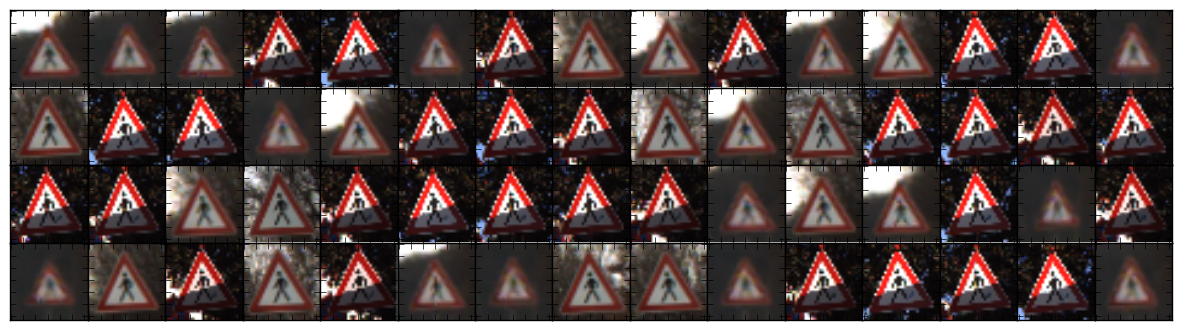

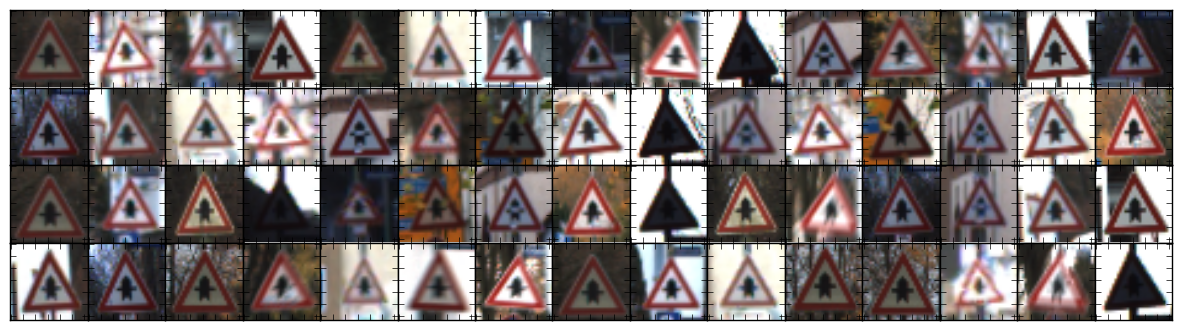

In [29]:
print('Test Images for class 27 and 11')
fig = plot_test_images(X_test[y_test == 27, :, :, :])
fig_ = plot_test_images(X_test[y_test == 11, :, :, :])
plt.show()

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [30]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
with tf.Session(config=config) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('nets/'))
    y_test_pred_top5 = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=10), feed_dict={x: X_img_test, keep_prob: 1.0})

[39 40 33 42  6  4 37 16  2 11]
[  8.12e-01   1.78e-01   1.07e-02   3.98e-10   5.65e-15   2.04e-16
   1.19e-17   3.83e-19   3.63e-20   1.06e-21]


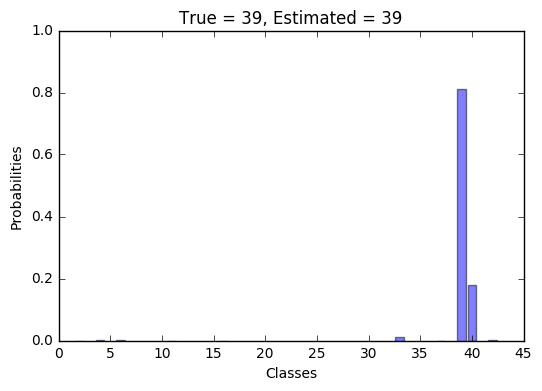

[29 28 22 24 25 26 23  0  3 38]
[ 0.67  0.19  0.04  0.03  0.02  0.01  0.01  0.01  0.    0.  ]


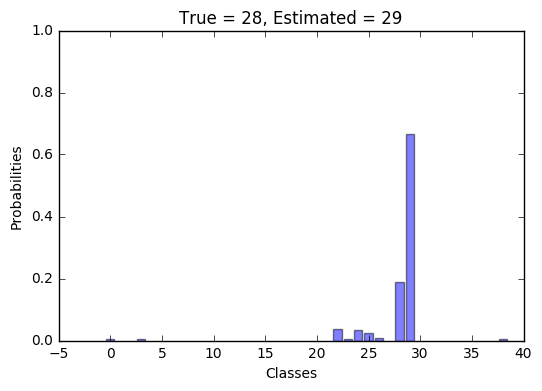

[ 2  1  5  7  4  3 10 13  0  6]
[  5.87e-01   4.12e-01   3.77e-04   4.00e-05   1.85e-07   1.15e-09
   7.87e-12   2.70e-13   1.22e-15   8.47e-19]


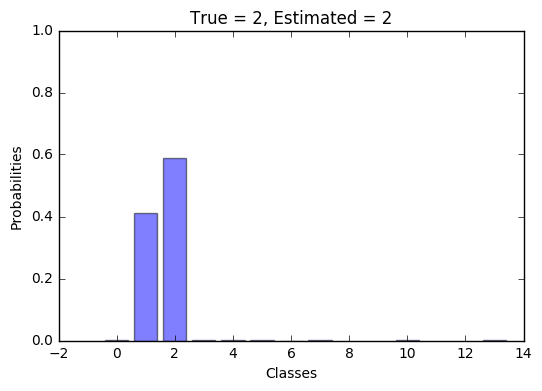

[14 17 13 12  1 10 11 18 35 21]
[  1.00e+00   2.31e-05   1.59e-07   5.09e-13   4.55e-17   6.27e-18
   2.88e-18   2.72e-18   3.47e-21   7.86e-22]


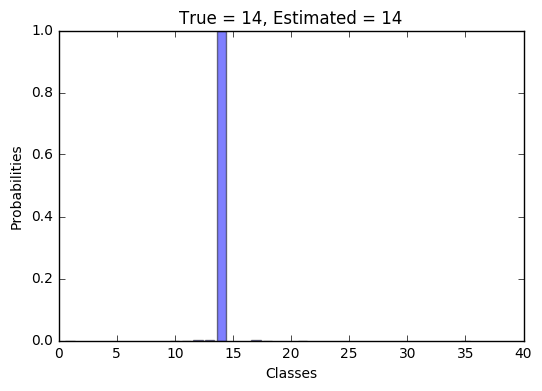

[12 13  0  1  2  3  4  5  6  7]
[  1.00e+00   3.12e-22   0.00e+00   0.00e+00   0.00e+00   0.00e+00
   0.00e+00   0.00e+00   0.00e+00   0.00e+00]


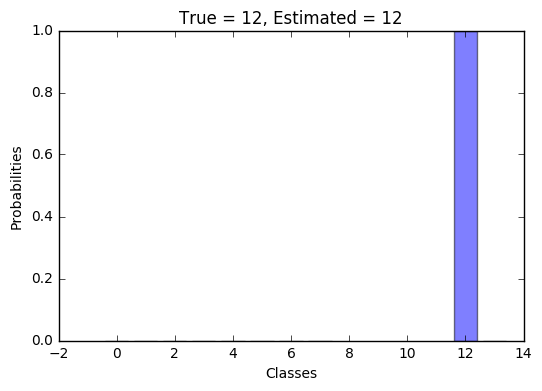

In [46]:
for i in range(len(y_new_true)):
#     print(y_new_true[i])
    plt.bar(y_test_pred_top5.indices[i,:], y_test_pred_top5.values[i,:], align="center", alpha=.5 )
    print(y_test_pred_top5.indices[i,:])
    print(y_test_pred_top5.values[i,:])
    plt.title('True = %d, Estimated = %d' %(y_new_true[i], y_new_pred[i]))
    plt.ylim([0, 1])
    plt.xlabel('Classes')
    plt.ylabel('Probabilities')
    plt.savefig('top_prob_' + str(i))
    plt.show()


Test Images for class 28 and 29


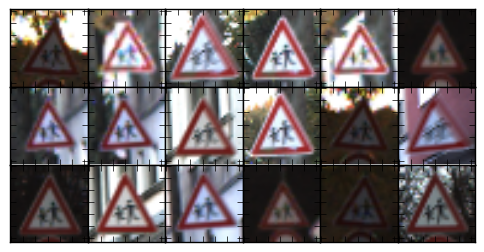

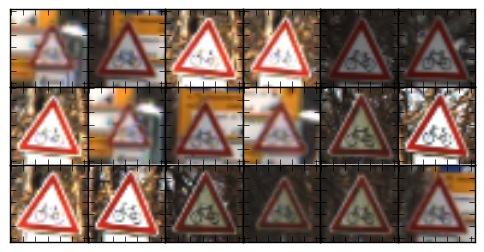

In [51]:
print('Test Images for class 28 and 29')
fig = plot_test_images(X_test[y_test == 28, :, :, :], 6, 3)
plt.savefig('test_28s.png')
plt.show()

fig_ = plot_test_images(X_test[y_test == 29, :, :, :], 6, 3)
plt.savefig('test_29s.png')
plt.show()

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 